**Objective**

The objective of this challenge is to build a machine learning model that helps predict the location and extent of floods in southern Malawi.


**Rules and Evaluation**

The error metric for this competition is the Root Mean Squared Error.

For every row in the dataset, submission files should contain 2 columns: Square_ID and target_2019.

In [151]:
#load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder  
from sklearn.preprocessing import StandardScaler  
from scipy import sparse
from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb
from math import sqrt
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform, randint
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, RandomizedSearchCV
import random

In [3]:
#load data
train = pd.read_csv("Train.csv")
submission = pd.read_csv("SampleSubmission.csv")

In [4]:
train.head()

,X,Y,target_2015,elevation,precip 2014-11-16 - 2014-11-23,precip 2014-11-23 - 2014-11-30,precip 2014-11-30 - 2014-12-07,precip 2014-12-07 - 2014-12-14,precip 2014-12-14 - 2014-12-21,precip 2014-12-21 - 2014-12-28,...,precip 2019-03-24 - 2019-03-31,precip 2019-03-31 - 2019-04-07,precip 2019-04-07 - 2019-04-14,precip 2019-04-14 - 2019-04-21,precip 2019-04-21 - 2019-04-28,precip 2019-04-28 - 2019-05-05,precip 2019-05-05 - 2019-05-12,precip 2019-05-12 - 2019-05-19,LC_Type1_mode,Square_ID
0,34.26,-15.91,0.0,887.764222,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,9,4e3c3896-14ce-11ea-bce5-f49634744a41
1,34.26,-15.90,0.0,743.403912,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,9,4e3c3897-14ce-11ea-bce5-f49634744a41
2,34.26,-15.89,0.0,565.728343,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,9,4e3c3898-14ce-11ea-bce5-f49634744a41
3,34.26,-15.88,0.0,443.392774,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,10,4e3c3899-14ce-11ea-bce5-f49634744a41
4,34.26,-15.87,0.0,437.443428,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,10,4e3c389a-14ce-11ea-bce5-f49634744a41


In [5]:
submission.head()

,Square_ID,target_2019
0,4e3c3896-14ce-11ea-bce5-f49634744a41,0.109
1,4e3c3897-14ce-11ea-bce5-f49634744a41,0.504
2,4e3c3898-14ce-11ea-bce5-f49634744a41,0.021
3,4e3c3899-14ce-11ea-bce5-f49634744a41,0.827
4,4e3c389a-14ce-11ea-bce5-f49634744a41,0.786


**Exploratory Data Analysis**

In [6]:
#summary
train.describe()

,X,Y,target_2015,elevation,precip 2014-11-16 - 2014-11-23,precip 2014-11-23 - 2014-11-30,precip 2014-11-30 - 2014-12-07,precip 2014-12-07 - 2014-12-14,precip 2014-12-14 - 2014-12-21,precip 2014-12-21 - 2014-12-28,...,precip 2019-03-17 - 2019-03-24,precip 2019-03-24 - 2019-03-31,precip 2019-03-31 - 2019-04-07,precip 2019-04-07 - 2019-04-14,precip 2019-04-14 - 2019-04-21,precip 2019-04-21 - 2019-04-28,precip 2019-04-28 - 2019-05-05,precip 2019-05-05 - 2019-05-12,precip 2019-05-12 - 2019-05-19,LC_Type1_mode
count,16466.000000,16466.000000,16466.000000,16466.000000,16466.000000,16466.000000,16466.000000,16466.000000,16466.000000,16466.000000,...,16466.000000,16466.000000,16466.000000,16466.000000,16466.000000,16466.000000,16466.000000,16466.000000,16466.000000,16466.00000
mean,35.077656,-15.813802,0.076609,592.848206,1.610760,2.502058,1.162076,8.270610,8.892459,9.572821,...,35.637354,2.126234,3.453395,3.559366,9.127677,1.660709,0.526144,0.968101,1.585743,10.73175
std,0.392395,0.359789,0.228734,354.790357,4.225461,8.631846,4.396676,4.263375,3.760052,4.523767,...,14.519169,3.734829,8.007248,3.820294,6.868937,4.418032,1.494935,3.690698,4.651863,2.02610
min,34.260000,-16.640000,0.000000,45.541444,0.000000,0.000000,0.000000,1.411452,3.580342,1.254098,...,15.803429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.00000
25%,34.760000,-16.070000,0.000000,329.063852,0.000000,0.000000,0.000000,5.548440,5.905440,6.179885,...,22.021763,0.000000,0.000000,0.000000,4.352528,0.000000,0.000000,0.000000,0.000000,9.00000
50%,35.050000,-15.800000,0.000000,623.000000,0.000000,0.000000,0.000000,7.941822,8.618390,8.786780,...,34.275716,0.896323,0.000000,2.607053,7.862453,0.000000,0.000000,0.000000,0.000000,10.00000
75%,35.390000,-15.520000,0.000000,751.434813,1.261848,0.000000,0.000000,10.887235,10.960668,12.670775,...,44.253897,2.076590,2.914996,6.390000,13.459070,0.000000,0.000000,0.000000,0.000000,12.00000
max,35.860000,-15.210000,1.000000,2803.303645,19.354969,41.023858,22.020803,18.870675,23.044340,21.757828,...,72.123185,16.403638,37.059980,12.979454,46.367849,19.475846,6.914834,18.170051,20.092777,17.00000


In [7]:
#check for missing data
train.isnull().sum()

X                                 0
Y                                 0
target_2015                       0
elevation                         0
precip 2014-11-16 - 2014-11-23    0
precip 2014-11-23 - 2014-11-30    0
precip 2014-11-30 - 2014-12-07    0
precip 2014-12-07 - 2014-12-14    0
precip 2014-12-14 - 2014-12-21    0
precip 2014-12-21 - 2014-12-28    0
precip 2014-12-28 - 2015-01-04    0
precip 2015-01-04 - 2015-01-11    0
precip 2015-01-11 - 2015-01-18    0
precip 2015-01-18 - 2015-01-25    0
precip 2015-01-25 - 2015-02-01    0
precip 2015-02-01 - 2015-02-08    0
precip 2015-02-08 - 2015-02-15    0
precip 2015-02-15 - 2015-02-22    0
precip 2015-02-22 - 2015-03-01    0
precip 2015-03-01 - 2015-03-08    0
precip 2015-03-08 - 2015-03-15    0
precip 2019-01-20 - 2019-01-27    0
precip 2019-01-27 - 2019-02-03    0
precip 2019-02-03 - 2019-02-10    0
precip 2019-02-10 - 2019-02-17    0
precip 2019-02-17 - 2019-02-24    0
precip 2019-02-24 - 2019-03-03    0
precip 2019-03-03 - 2019-03-

In [8]:
train_list = list(train.columns) 

In [9]:
train_list

['X',
 'Y',
 'target_2015',
 'elevation',
 'precip 2014-11-16 - 2014-11-23',
 'precip 2014-11-23 - 2014-11-30',
 'precip 2014-11-30 - 2014-12-07',
 'precip 2014-12-07 - 2014-12-14',
 'precip 2014-12-14 - 2014-12-21',
 'precip 2014-12-21 - 2014-12-28',
 'precip 2014-12-28 - 2015-01-04',
 'precip 2015-01-04 - 2015-01-11',
 'precip 2015-01-11 - 2015-01-18',
 'precip 2015-01-18 - 2015-01-25',
 'precip 2015-01-25 - 2015-02-01',
 'precip 2015-02-01 - 2015-02-08',
 'precip 2015-02-08 - 2015-02-15',
 'precip 2015-02-15 - 2015-02-22',
 'precip 2015-02-22 - 2015-03-01',
 'precip 2015-03-01 - 2015-03-08',
 'precip 2015-03-08 - 2015-03-15',
 'precip 2019-01-20 - 2019-01-27',
 'precip 2019-01-27 - 2019-02-03',
 'precip 2019-02-03 - 2019-02-10',
 'precip 2019-02-10 - 2019-02-17',
 'precip 2019-02-17 - 2019-02-24',
 'precip 2019-02-24 - 2019-03-03',
 'precip 2019-03-03 - 2019-03-10',
 'precip 2019-03-10 - 2019-03-17',
 'precip 2019-03-17 - 2019-03-24',
 'precip 2019-03-24 - 2019-03-31',
 'precip 2019

In [10]:
train2 = pd.read_csv("Train2.csv")

In [11]:
train_cluster = train[['Square_ID','X','Y']]

In [12]:
#no need to generate x,y,z coordinates since these are latitude and longitude
#x = cos(lat) * cos(lon)
#y = cos(lat) * sin(lon), 
#z = sin(lat) 


In [13]:
train_x_y = train[['X','Y']]

In [14]:
#find optimial number of clusters
from sklearn.preprocessing import OneHotEncoder  
from sklearn.preprocessing import StandardScaler 

ss = StandardScaler()
ss.fit(train_x_y)
data_transformed = ss.transform(train_x_y)

In [15]:
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

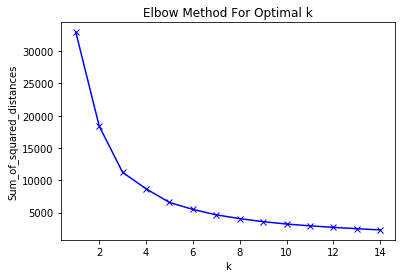

In [16]:
#find optimal cluster
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [17]:
#generate clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
kmeans.fit(data_transformed)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [18]:
labels = kmeans.predict(data_transformed)
centroids = kmeans.cluster_centers_

In [19]:
#convert labels and centroids to pd
labels_df = pd.Series(labels)
#centroids_df = pd.Series(centroids)

In [20]:
labels_df.columns = ['Cluster']

In [21]:
labels_df.head()

0    4
1    4
2    4
3    4
4    4
dtype: int32

In [22]:
#merge train data to cluster
train_combine = pd.concat([train, labels_df],axis = 1)
#score_target = pd.concat([score_target_drop, target_df], axis = 1)

In [23]:
train_combine.head()

,X,Y,target_2015,elevation,precip 2014-11-16 - 2014-11-23,precip 2014-11-23 - 2014-11-30,precip 2014-11-30 - 2014-12-07,precip 2014-12-07 - 2014-12-14,precip 2014-12-14 - 2014-12-21,precip 2014-12-21 - 2014-12-28,...,precip 2019-03-31 - 2019-04-07,precip 2019-04-07 - 2019-04-14,precip 2019-04-14 - 2019-04-21,precip 2019-04-21 - 2019-04-28,precip 2019-04-28 - 2019-05-05,precip 2019-05-05 - 2019-05-12,precip 2019-05-12 - 2019-05-19,LC_Type1_mode,Square_ID,0
0,34.26,-15.91,0.0,887.764222,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,1.68,0.0,0.0,0.0,0.0,0.0,0.0,9,4e3c3896-14ce-11ea-bce5-f49634744a41,4
1,34.26,-15.90,0.0,743.403912,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,1.68,0.0,0.0,0.0,0.0,0.0,0.0,9,4e3c3897-14ce-11ea-bce5-f49634744a41,4
2,34.26,-15.89,0.0,565.728343,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,1.68,0.0,0.0,0.0,0.0,0.0,0.0,9,4e3c3898-14ce-11ea-bce5-f49634744a41,4
3,34.26,-15.88,0.0,443.392774,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,1.68,0.0,0.0,0.0,0.0,0.0,0.0,10,4e3c3899-14ce-11ea-bce5-f49634744a41,4
4,34.26,-15.87,0.0,437.443428,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,1.68,0.0,0.0,0.0,0.0,0.0,0.0,10,4e3c389a-14ce-11ea-bce5-f49634744a41,4


In [24]:
train_combine2 = pd.concat([train2, labels_df],axis = 1)

In [25]:
train_combine2.head()

,X,Y,target_2015,elevation,WEEK_1_2015,WEEK_2_2015,WEEK_3_2015,WEEK_4_2015,WEEK_5_2015,WEEK_6_2015,...,WEEK_11_2019,WEEK_12_2019,WEEK_13_2019,WEEK_14_2019,WEEK_15_2019,WEEK_16_2019,WEEK_17_2019,LC_Type1_mode,Square_ID,0
0,34.26,-15.91,0.0,887.764222,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,1.68,0.0,0.0,0.0,0.0,0.0,0.0,9,4e3c3896-14ce-11ea-bce5-f49634744a41,4
1,34.26,-15.90,0.0,743.403912,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,1.68,0.0,0.0,0.0,0.0,0.0,0.0,9,4e3c3897-14ce-11ea-bce5-f49634744a41,4
2,34.26,-15.89,0.0,565.728343,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,1.68,0.0,0.0,0.0,0.0,0.0,0.0,9,4e3c3898-14ce-11ea-bce5-f49634744a41,4
3,34.26,-15.88,0.0,443.392774,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,1.68,0.0,0.0,0.0,0.0,0.0,0.0,10,4e3c3899-14ce-11ea-bce5-f49634744a41,4
4,34.26,-15.87,0.0,437.443429,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,1.68,0.0,0.0,0.0,0.0,0.0,0.0,10,4e3c389a-14ce-11ea-bce5-f49634744a41,4


In [26]:
train_list = list(train_combine2.columns) 
train_list

['X',
 'Y',
 'target_2015',
 'elevation',
 'WEEK_1_2015',
 'WEEK_2_2015',
 'WEEK_3_2015',
 'WEEK_4_2015',
 'WEEK_5_2015',
 'WEEK_6_2015',
 'WEEK_7_2015',
 'WEEK_8_2015',
 'WEEK_9_2015',
 'WEEK_10_2015',
 'WEEK_11_2015',
 'WEEK_12_2015',
 'WEEK_13_2015',
 'WEEK_14_2015',
 'WEEK_15_2015',
 'WEEK_16_2015',
 'WEEK_17_2015',
 'WEEK_1_2019',
 'WEEK_2_2019',
 'WEEK_3_2019',
 'WEEK_4_2019',
 'WEEK_5_2019',
 'WEEK_6_2019',
 'WEEK_7_2019',
 'WEEK_8_2019',
 'WEEK_9_2019',
 'WEEK_10_2019',
 'WEEK_11_2019',
 'WEEK_12_2019',
 'WEEK_13_2019',
 'WEEK_14_2019',
 'WEEK_15_2019',
 'WEEK_16_2019',
 'WEEK_17_2019',
 'LC_Type1_mode',
 'Square_ID',
 0]

In [27]:
train_df = train_combine2[['Square_ID','LC_Type1_mode','elevation',0,
 'WEEK_1_2015',
 'WEEK_2_2015',
 'WEEK_3_2015',
 'WEEK_4_2015',
 'WEEK_5_2015',
 'WEEK_6_2015',
 'WEEK_7_2015',
 'WEEK_8_2015',
 'WEEK_9_2015',
 'WEEK_10_2015',
 'WEEK_11_2015',
 'WEEK_12_2015',
 'WEEK_13_2015',
 'WEEK_14_2015',
 'WEEK_15_2015',
 'WEEK_16_2015',
 'WEEK_17_2015',
'target_2015']]

In [28]:
test_df = train_combine2[['Square_ID','LC_Type1_mode','elevation',0,'WEEK_1_2019',
 'WEEK_2_2019',
 'WEEK_3_2019',
 'WEEK_4_2019',
 'WEEK_5_2019',
 'WEEK_6_2019',
 'WEEK_7_2019',
 'WEEK_8_2019',
 'WEEK_9_2019',
 'WEEK_10_2019',
 'WEEK_11_2019',
 'WEEK_12_2019',
 'WEEK_13_2019',
 'WEEK_14_2019',
 'WEEK_15_2019',
 'WEEK_16_2019',
 'WEEK_17_2019']]

In [29]:
train_df.columns = ['Square_ID','LC_Type1_mode','elevation',"cluster",'WEEK_1','WEEK_2',
 'WEEK_3','WEEK_4','WEEK_5','WEEK_6','WEEK_7','WEEK_8','WEEK_9','WEEK_10','WEEK_11',
                    'WEEK_12','WEEK_13','WEEK_14','WEEK_15','WEEK_16','WEEK_17','target']

In [30]:
test_df.columns = ['Square_ID','LC_Type1_mode','elevation','cluster','WEEK_1','WEEK_2',
 'WEEK_3',
 'WEEK_4',
 'WEEK_5',
 'WEEK_6',
 'WEEK_7',
 'WEEK_8',
 'WEEK_9',
 'WEEK_10',
 'WEEK_11',
 'WEEK_12',
 'WEEK_13',
 'WEEK_14','WEEK_15','WEEK_16','WEEK_17']

In [31]:
#Modelling

In [32]:
#load modelling data
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder  
from sklearn.preprocessing import StandardScaler  
from scipy import sparse
from catboost import CatBoostClassifier, Pool
import lightgbm as lgb
import xgboost as xgb
from math import sqrt
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform, randint
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, RandomizedSearchCV
import random
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, recall_score, precision_score, f1_score, confusion_matrix, recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier

In [89]:
X = train_df.drop(['target'], axis=1)
y = train_df.target

In [90]:
#generate train and test data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1, random_state=100)
X_train = X
X_test = X
y_train = y
y_test = y

In [91]:
#Categorical data
train_cat = X_train[['LC_Type1_mode',"cluster"]] 
train_cat2 = pd.get_dummies(train_cat, columns=['LC_Type1_mode',"cluster"], drop_first=False)
train_cat2.reset_index(drop=True, inplace=True)

In [92]:
test_cat = X_test[['LC_Type1_mode',"cluster"]]
test_cat2 = pd.get_dummies(test_cat, columns=['LC_Type1_mode',"cluster"], drop_first=False)
test_cat2.reset_index(drop=True, inplace=True)

In [93]:
#train
scaler = preprocessing.MinMaxScaler()
to_scale_df = X_train[['elevation','WEEK_1','WEEK_2',
 'WEEK_3','WEEK_4','WEEK_5','WEEK_6','WEEK_7','WEEK_8','WEEK_9','WEEK_10','WEEK_11',
                    'WEEK_12','WEEK_13','WEEK_14','WEEK_15','WEEK_16','WEEK_17']]
train_scaled_df = scaler.fit_transform(to_scale_df)
train_scaled_df = pd.DataFrame(train_scaled_df, columns=['elevation','WEEK_1','WEEK_2',
 'WEEK_3','WEEK_4','WEEK_5','WEEK_6','WEEK_7','WEEK_8','WEEK_9','WEEK_10','WEEK_11',
                    'WEEK_12','WEEK_13','WEEK_14','WEEK_15','WEEK_16','WEEK_17'])
train_scaled_df.reset_index(drop=True, inplace=True)

In [94]:
#test
scaler = preprocessing.MinMaxScaler()
to_scale_df = X_test[['elevation','WEEK_1','WEEK_2',
 'WEEK_3','WEEK_4','WEEK_5','WEEK_6','WEEK_7','WEEK_8','WEEK_9','WEEK_10','WEEK_11',
                    'WEEK_12','WEEK_13','WEEK_14','WEEK_15','WEEK_16','WEEK_17']] 
test_scaled_df = scaler.fit_transform(to_scale_df)
test_scaled_df = pd.DataFrame(test_scaled_df, columns=['elevation','WEEK_1','WEEK_2',
 'WEEK_3','WEEK_4','WEEK_5','WEEK_6','WEEK_7','WEEK_8','WEEK_9','WEEK_10','WEEK_11',
                    'WEEK_12','WEEK_13','WEEK_14','WEEK_15','WEEK_16','WEEK_17'])
test_scaled_df.reset_index(drop=True, inplace=True)

In [95]:
#train square id
train_id = X_train['Square_ID']
train_id .reset_index(drop=True, inplace=True)

In [112]:
#test square id
test_id = X_test['Square_ID']
test_id .reset_index(drop=True, inplace=True)

In [113]:
#combine
train_outcome = y_train
train_outcome.reset_index(drop=True, inplace=True)
train_df_final = pd.concat([train_scaled_df, train_cat2,train_outcome], axis=1)
train_df_final.head()

,elevation,WEEK_1,WEEK_2,WEEK_3,WEEK_4,WEEK_5,WEEK_6,WEEK_7,WEEK_8,WEEK_9,...,LC_Type1_mode_12,LC_Type1_mode_13,LC_Type1_mode_14,LC_Type1_mode_17,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,target
0,0.305401,0.0,0.0,0.0,0.769368,0.563732,0.535691,0.909368,0.407291,0.0,...,0,0,0,0,0,0,0,0,1,0.0
1,0.253054,0.0,0.0,0.0,0.769368,0.563732,0.535691,0.909368,0.407291,0.0,...,0,0,0,0,0,0,0,0,1,0.0
2,0.188626,0.0,0.0,0.0,0.769368,0.563732,0.535691,0.909368,0.407291,0.0,...,0,0,0,0,0,0,0,0,1,0.0
3,0.144266,0.0,0.0,0.0,0.769368,0.563732,0.535691,0.909368,0.407291,0.0,...,0,0,0,0,0,0,0,0,1,0.0
4,0.142109,0.0,0.0,0.0,0.769368,0.563732,0.535691,0.909368,0.407291,0.0,...,0,0,0,0,0,0,0,0,1,0.0


In [114]:
train_df_final.shape

(16466, 36)

In [115]:
train_df_final.columns

Index(['elevation', 'WEEK_1', 'WEEK_2', 'WEEK_3', 'WEEK_4', 'WEEK_5', 'WEEK_6',
       'WEEK_7', 'WEEK_8', 'WEEK_9', 'WEEK_10', 'WEEK_11', 'WEEK_12',
       'WEEK_13', 'WEEK_14', 'WEEK_15', 'WEEK_16', 'WEEK_17',
       'LC_Type1_mode_2', 'LC_Type1_mode_4', 'LC_Type1_mode_5',
       'LC_Type1_mode_7', 'LC_Type1_mode_8', 'LC_Type1_mode_9',
       'LC_Type1_mode_10', 'LC_Type1_mode_11', 'LC_Type1_mode_12',
       'LC_Type1_mode_13', 'LC_Type1_mode_14', 'LC_Type1_mode_17', 'cluster_0',
       'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'target'],
      dtype='object')

In [116]:
#train_df_final = train_df_final[['elevation', 'WEEK_1', 'WEEK_2', 'WEEK_3', 'WEEK_4', 'WEEK_5', 'WEEK_6',
#       'WEEK_7', 'WEEK_8', 'WEEK_9', 'WEEK_10', 'WEEK_11', 'WEEK_12',
#       'WEEK_13', 'WEEK_14', 'WEEK_15', 'WEEK_16', 'WEEK_17',
#       'LC_Type1_mode_2', 'LC_Type1_mode_4', 'LC_Type1_mode_5',
#       'LC_Type1_mode_8', 'LC_Type1_mode_9', 'LC_Type1_mode_10',
#       'LC_Type1_mode_11', 'LC_Type1_mode_12', 'LC_Type1_mode_13',
#       'LC_Type1_mode_14', 'LC_Type1_mode_17', 'cluster_0', 'cluster_1',
#       'cluster_2', 'cluster_3', 'cluster_4', 'target']]

In [117]:
#combine
test_outcome = y_test
test_outcome.reset_index(drop=True, inplace=True)
test_df_final = pd.concat([test_scaled_df, test_cat2,test_outcome], axis=1)
test_df_final.head()

,elevation,WEEK_1,WEEK_2,WEEK_3,WEEK_4,WEEK_5,WEEK_6,WEEK_7,WEEK_8,WEEK_9,...,LC_Type1_mode_12,LC_Type1_mode_13,LC_Type1_mode_14,LC_Type1_mode_17,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,target
0,0.305401,0.0,0.0,0.0,0.769368,0.563732,0.535691,0.909368,0.407291,0.0,...,0,0,0,0,0,0,0,0,1,0.0
1,0.253054,0.0,0.0,0.0,0.769368,0.563732,0.535691,0.909368,0.407291,0.0,...,0,0,0,0,0,0,0,0,1,0.0
2,0.188626,0.0,0.0,0.0,0.769368,0.563732,0.535691,0.909368,0.407291,0.0,...,0,0,0,0,0,0,0,0,1,0.0
3,0.144266,0.0,0.0,0.0,0.769368,0.563732,0.535691,0.909368,0.407291,0.0,...,0,0,0,0,0,0,0,0,1,0.0
4,0.142109,0.0,0.0,0.0,0.769368,0.563732,0.535691,0.909368,0.407291,0.0,...,0,0,0,0,0,0,0,0,1,0.0


In [118]:
test_df_final.shape

(16466, 36)

In [119]:
test_df_final.columns

Index(['elevation', 'WEEK_1', 'WEEK_2', 'WEEK_3', 'WEEK_4', 'WEEK_5', 'WEEK_6',
       'WEEK_7', 'WEEK_8', 'WEEK_9', 'WEEK_10', 'WEEK_11', 'WEEK_12',
       'WEEK_13', 'WEEK_14', 'WEEK_15', 'WEEK_16', 'WEEK_17',
       'LC_Type1_mode_2', 'LC_Type1_mode_4', 'LC_Type1_mode_5',
       'LC_Type1_mode_7', 'LC_Type1_mode_8', 'LC_Type1_mode_9',
       'LC_Type1_mode_10', 'LC_Type1_mode_11', 'LC_Type1_mode_12',
       'LC_Type1_mode_13', 'LC_Type1_mode_14', 'LC_Type1_mode_17', 'cluster_0',
       'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'target'],
      dtype='object')

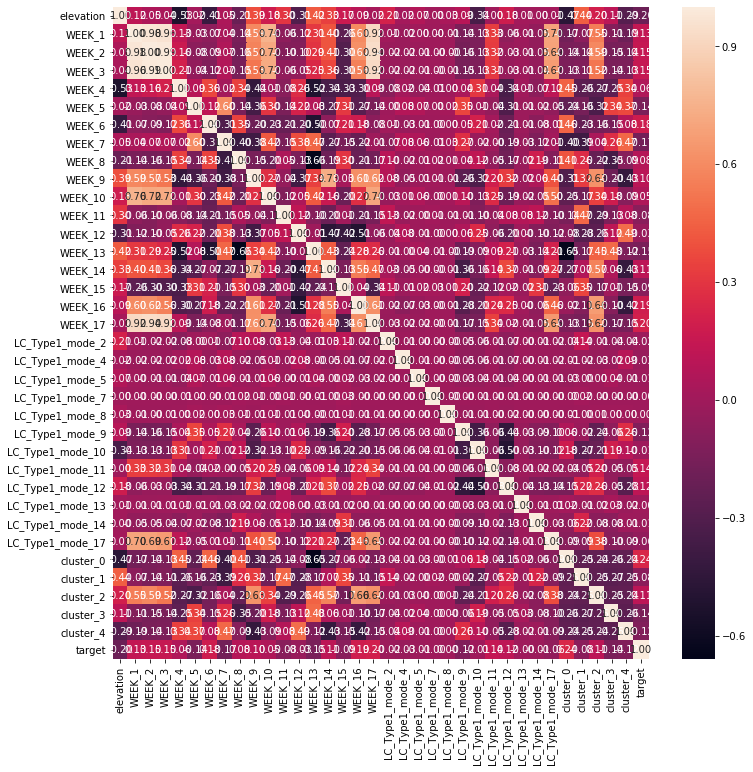

In [120]:
#check for correlation
import dython
from dython import nominal

#correlation
nominal.associations(train_df_final, correlation_ratio=False, figsize=(12,12))

In [121]:
#build model - #xgboost, catboost, lightgbm, naive bayes, logistic regression

In [122]:
#Xgboost model + parameter tuning + cross validation

In [123]:
#split training data set
X_train1 = train_df_final.drop(['target'], axis=1)
y_train1 = train_df_final.target

#split test dataset
X_test1 = test_df_final.drop(['target'], axis=1)
y_test1 = test_df_final.target

In [124]:
params = {'colsample_bytree': uniform(0.7, 0.3),
          'gamma': uniform(0, 0.5),
          'learning_rate': uniform(0.003, 0.3), # default 0.1 
          'max_depth': randint(2, 6), # default 3
          'n_estimators': randint(100, 250), # default 100
          'subsample': uniform(0.6, 0.4)}
xgb_model = xgb.XGBRegressor(objective="reg:squarederror",random_state=1)
time_split = TimeSeriesSplit(n_splits = 8)
xgb_search = RandomizedSearchCV(xgb_model,param_distributions=params, 
                                random_state=1, n_iter=4, cv=time_split, 
                                  verbose=1, n_jobs=1, return_train_score=True)  

In [125]:
xgb_search.fit(X_train1, y_train1)

Fitting 8 folds for each of 4 candidates, totalling 32 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:  2.0min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=8),
                   error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a2a9d9630>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a2a9d9d30>,
      

In [126]:
predicted_xgb = xgb_search.predict(X_test1)
rms = sqrt(mean_squared_error(y_test1, predicted_xgb ))
print ('RMSE:', rms)

RMSE: 0.14087743584102982


In [127]:
##Catboost model + parameter tuning + cross validation

In [128]:
#split training data set
X_train2 = train_df_final.drop(['target'], axis=1)
y_train2 = train_df_final.target

#split test dataset
X_test2 = test_df_final.drop(['target'], axis=1)
y_test2 = test_df_final.target

In [129]:
model=CatBoostRegressor(iterations=500, depth=10, learning_rate=0.01, loss_function='RMSE')

In [130]:
model.fit(X_train2, y_train2,eval_set=(X_test2, y_test2),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2273929	test: 0.2273929	best: 0.2273929 (0)	total: 517ms	remaining: 4m 17s
1:	learn: 0.2261135	test: 0.2261135	best: 0.2261135 (1)	total: 1.05s	remaining: 4m 21s
2:	learn: 0.2248815	test: 0.2248815	best: 0.2248815 (2)	total: 1.8s	remaining: 4m 59s
3:	learn: 0.2236212	test: 0.2236212	best: 0.2236212 (3)	total: 2.28s	remaining: 4m 42s
4:	learn: 0.2223742	test: 0.2223742	best: 0.2223742 (4)	total: 2.83s	remaining: 4m 40s
5:	learn: 0.2211308	test: 0.2211308	best: 0.2211308 (5)	total: 3.35s	remaining: 4m 35s
6:	learn: 0.2199244	test: 0.2199244	best: 0.2199244 (6)	total: 3.93s	remaining: 4m 36s
7:	learn: 0.2186709	test: 0.2186709	best: 0.2186709 (7)	total: 4.31s	remaining: 4m 25s
8:	learn: 0.2175175	test: 0.2175175	best: 0.2175175 (8)	total: 4.81s	remaining: 4m 22s
9:	learn: 0.2163412	test: 0.2163412	best: 0.2163412 (9)	total: 5.21s	remaining: 4m 15s
10:	learn: 0.2151181	test: 0.2151181	best: 0.2151181 (10)	total: 5.71s	remaining: 4m 13s
11:	learn: 0.2139579	test: 0.2139579	best:

93:	learn: 0.1563430	test: 0.1563430	best: 0.1563430 (93)	total: 57s	remaining: 4m 6s
94:	learn: 0.1559518	test: 0.1559518	best: 0.1559518 (94)	total: 57.9s	remaining: 4m 6s
95:	learn: 0.1555504	test: 0.1555504	best: 0.1555504 (95)	total: 58.8s	remaining: 4m 7s
96:	learn: 0.1551649	test: 0.1551649	best: 0.1551649 (96)	total: 59.7s	remaining: 4m 7s
97:	learn: 0.1548443	test: 0.1548443	best: 0.1548443 (97)	total: 1m	remaining: 4m 7s
98:	learn: 0.1544717	test: 0.1544717	best: 0.1544717 (98)	total: 1m	remaining: 4m 6s
99:	learn: 0.1541569	test: 0.1541569	best: 0.1541569 (99)	total: 1m 1s	remaining: 4m 5s
100:	learn: 0.1537842	test: 0.1537842	best: 0.1537842 (100)	total: 1m 1s	remaining: 4m 3s
101:	learn: 0.1534426	test: 0.1534426	best: 0.1534426 (101)	total: 1m 2s	remaining: 4m 3s
102:	learn: 0.1530778	test: 0.1530778	best: 0.1530778 (102)	total: 1m 2s	remaining: 4m 1s
103:	learn: 0.1527472	test: 0.1527472	best: 0.1527472 (103)	total: 1m 3s	remaining: 4m
104:	learn: 0.1524121	test: 0.15241

184:	learn: 0.1350150	test: 0.1350150	best: 0.1350150 (184)	total: 1m 44s	remaining: 2m 58s
185:	learn: 0.1348356	test: 0.1348356	best: 0.1348356 (185)	total: 1m 45s	remaining: 2m 57s
186:	learn: 0.1346790	test: 0.1346790	best: 0.1346790 (186)	total: 1m 45s	remaining: 2m 56s
187:	learn: 0.1345547	test: 0.1345547	best: 0.1345547 (187)	total: 1m 46s	remaining: 2m 55s
188:	learn: 0.1344210	test: 0.1344210	best: 0.1344210 (188)	total: 1m 46s	remaining: 2m 55s
189:	learn: 0.1342892	test: 0.1342892	best: 0.1342892 (189)	total: 1m 46s	remaining: 2m 54s
190:	learn: 0.1341510	test: 0.1341510	best: 0.1341510 (190)	total: 1m 47s	remaining: 2m 53s
191:	learn: 0.1340114	test: 0.1340114	best: 0.1340114 (191)	total: 1m 47s	remaining: 2m 52s
192:	learn: 0.1338760	test: 0.1338760	best: 0.1338760 (192)	total: 1m 48s	remaining: 2m 51s
193:	learn: 0.1337567	test: 0.1337567	best: 0.1337567 (193)	total: 1m 48s	remaining: 2m 51s
194:	learn: 0.1336390	test: 0.1336390	best: 0.1336390 (194)	total: 1m 48s	remain

274:	learn: 0.1267773	test: 0.1267773	best: 0.1267773 (274)	total: 2m 27s	remaining: 2m
275:	learn: 0.1267111	test: 0.1267111	best: 0.1267111 (275)	total: 2m 27s	remaining: 1m 59s
276:	learn: 0.1266201	test: 0.1266201	best: 0.1266201 (276)	total: 2m 27s	remaining: 1m 59s
277:	learn: 0.1265680	test: 0.1265680	best: 0.1265680 (277)	total: 2m 28s	remaining: 1m 58s
278:	learn: 0.1264865	test: 0.1264865	best: 0.1264865 (278)	total: 2m 28s	remaining: 1m 57s
279:	learn: 0.1264238	test: 0.1264238	best: 0.1264238 (279)	total: 2m 29s	remaining: 1m 57s
280:	learn: 0.1263285	test: 0.1263285	best: 0.1263285 (280)	total: 2m 29s	remaining: 1m 56s
281:	learn: 0.1262496	test: 0.1262496	best: 0.1262496 (281)	total: 2m 29s	remaining: 1m 55s
282:	learn: 0.1261863	test: 0.1261863	best: 0.1261863 (282)	total: 2m 30s	remaining: 1m 55s
283:	learn: 0.1261468	test: 0.1261468	best: 0.1261468 (283)	total: 2m 30s	remaining: 1m 54s
284:	learn: 0.1260944	test: 0.1260944	best: 0.1260944 (284)	total: 2m 30s	remaining:

364:	learn: 0.1224802	test: 0.1224802	best: 0.1224802 (364)	total: 3m	remaining: 1m 6s
365:	learn: 0.1224472	test: 0.1224472	best: 0.1224472 (365)	total: 3m 1s	remaining: 1m 6s
366:	learn: 0.1224070	test: 0.1224070	best: 0.1224070 (366)	total: 3m 1s	remaining: 1m 5s
367:	learn: 0.1223873	test: 0.1223873	best: 0.1223873 (367)	total: 3m 2s	remaining: 1m 5s
368:	learn: 0.1223527	test: 0.1223527	best: 0.1223527 (368)	total: 3m 2s	remaining: 1m 4s
369:	learn: 0.1223016	test: 0.1223016	best: 0.1223016 (369)	total: 3m 2s	remaining: 1m 4s
370:	learn: 0.1222486	test: 0.1222486	best: 0.1222486 (370)	total: 3m 3s	remaining: 1m 3s
371:	learn: 0.1221970	test: 0.1221970	best: 0.1221970 (371)	total: 3m 3s	remaining: 1m 3s
372:	learn: 0.1221663	test: 0.1221663	best: 0.1221663 (372)	total: 3m 3s	remaining: 1m 2s
373:	learn: 0.1221472	test: 0.1221472	best: 0.1221472 (373)	total: 3m 4s	remaining: 1m 2s
374:	learn: 0.1221016	test: 0.1221016	best: 0.1221016 (374)	total: 3m 4s	remaining: 1m 1s
375:	learn: 0

455:	learn: 0.1198442	test: 0.1198442	best: 0.1198442 (455)	total: 3m 42s	remaining: 21.5s
456:	learn: 0.1198313	test: 0.1198313	best: 0.1198313 (456)	total: 3m 43s	remaining: 21s
457:	learn: 0.1198235	test: 0.1198235	best: 0.1198235 (457)	total: 3m 43s	remaining: 20.5s
458:	learn: 0.1198069	test: 0.1198069	best: 0.1198069 (458)	total: 3m 43s	remaining: 20s
459:	learn: 0.1197934	test: 0.1197934	best: 0.1197934 (459)	total: 3m 44s	remaining: 19.5s
460:	learn: 0.1197710	test: 0.1197710	best: 0.1197710 (460)	total: 3m 44s	remaining: 19s
461:	learn: 0.1197438	test: 0.1197438	best: 0.1197438 (461)	total: 3m 45s	remaining: 18.5s
462:	learn: 0.1197193	test: 0.1197193	best: 0.1197193 (462)	total: 3m 45s	remaining: 18s
463:	learn: 0.1197103	test: 0.1197103	best: 0.1197103 (463)	total: 3m 46s	remaining: 17.5s
464:	learn: 0.1196970	test: 0.1196970	best: 0.1196970 (464)	total: 3m 46s	remaining: 17s
465:	learn: 0.1196657	test: 0.1196657	best: 0.1196657 (465)	total: 3m 47s	remaining: 16.6s
466:	lear

In [131]:
from sklearn.model_selection import GridSearchCV
model = CatBoostRegressor(loss_function='RMSE')

grid = {'learning_rate': [0.01, 0.1],
        'depth': [6,8,10],}

#grid_search_result = model.grid_search(grid, 
#                                       X=X_train2, 
#                                       y=X_train2, 
#                                       plot=True)

In [132]:
grid = GridSearchCV(estimator=model, param_grid = grid, cv = 5, n_jobs=-1)
grid.fit(X_train2, y_train2)

0:	learn: 0.2274221	total: 32.7ms	remaining: 32.7s
1:	learn: 0.2261560	total: 58.8ms	remaining: 29.4s
2:	learn: 0.2249069	total: 83.3ms	remaining: 27.7s
3:	learn: 0.2236576	total: 110ms	remaining: 27.4s
4:	learn: 0.2224978	total: 134ms	remaining: 26.6s
5:	learn: 0.2213346	total: 159ms	remaining: 26.3s
6:	learn: 0.2201837	total: 183ms	remaining: 25.9s
7:	learn: 0.2190427	total: 206ms	remaining: 25.6s
8:	learn: 0.2179156	total: 231ms	remaining: 25.4s
9:	learn: 0.2168423	total: 269ms	remaining: 26.7s
10:	learn: 0.2157255	total: 293ms	remaining: 26.3s
11:	learn: 0.2145939	total: 317ms	remaining: 26.1s
12:	learn: 0.2135652	total: 344ms	remaining: 26.1s
13:	learn: 0.2124926	total: 370ms	remaining: 26.1s
14:	learn: 0.2114762	total: 399ms	remaining: 26.2s
15:	learn: 0.2104055	total: 423ms	remaining: 26s
16:	learn: 0.2093822	total: 448ms	remaining: 25.9s
17:	learn: 0.2083567	total: 474ms	remaining: 25.9s
18:	learn: 0.2073926	total: 504ms	remaining: 26s
19:	learn: 0.2064372	total: 528ms	remainin

164:	learn: 0.1446221	total: 4.82s	remaining: 24.4s
165:	learn: 0.1444911	total: 4.84s	remaining: 24.3s
166:	learn: 0.1443628	total: 4.87s	remaining: 24.3s
167:	learn: 0.1442059	total: 4.89s	remaining: 24.2s
168:	learn: 0.1440421	total: 4.92s	remaining: 24.2s
169:	learn: 0.1439042	total: 4.95s	remaining: 24.1s
170:	learn: 0.1437705	total: 4.97s	remaining: 24.1s
171:	learn: 0.1436583	total: 5s	remaining: 24.1s
172:	learn: 0.1435258	total: 5.02s	remaining: 24s
173:	learn: 0.1434376	total: 5.06s	remaining: 24s
174:	learn: 0.1433040	total: 5.1s	remaining: 24.1s
175:	learn: 0.1432072	total: 5.14s	remaining: 24.1s
176:	learn: 0.1430710	total: 5.17s	remaining: 24.1s
177:	learn: 0.1429639	total: 5.21s	remaining: 24.1s
178:	learn: 0.1428262	total: 5.27s	remaining: 24.2s
179:	learn: 0.1427416	total: 5.3s	remaining: 24.1s
180:	learn: 0.1426134	total: 5.33s	remaining: 24.1s
181:	learn: 0.1425182	total: 5.36s	remaining: 24.1s
182:	learn: 0.1424115	total: 5.38s	remaining: 24s
183:	learn: 0.1422807	t

325:	learn: 0.1325225	total: 10.6s	remaining: 21.8s
326:	learn: 0.1324601	total: 10.6s	remaining: 21.9s
327:	learn: 0.1324247	total: 10.7s	remaining: 21.9s
328:	learn: 0.1323703	total: 10.8s	remaining: 22s
329:	learn: 0.1323328	total: 10.9s	remaining: 22s
330:	learn: 0.1322786	total: 10.9s	remaining: 22.1s
331:	learn: 0.1322519	total: 11s	remaining: 22.2s
332:	learn: 0.1322253	total: 11.1s	remaining: 22.3s
333:	learn: 0.1321883	total: 11.2s	remaining: 22.4s
334:	learn: 0.1321407	total: 11.3s	remaining: 22.4s
335:	learn: 0.1320875	total: 11.4s	remaining: 22.5s
336:	learn: 0.1320531	total: 11.5s	remaining: 22.6s
337:	learn: 0.1319937	total: 11.6s	remaining: 22.6s
338:	learn: 0.1319560	total: 11.7s	remaining: 22.7s
339:	learn: 0.1319206	total: 11.8s	remaining: 22.9s
340:	learn: 0.1318719	total: 11.9s	remaining: 23s
341:	learn: 0.1318435	total: 12.3s	remaining: 23.7s
342:	learn: 0.1318129	total: 12.6s	remaining: 24.2s
343:	learn: 0.1317667	total: 12.7s	remaining: 24.3s
344:	learn: 0.131742

490:	learn: 0.1274302	total: 18.4s	remaining: 19.1s
491:	learn: 0.1274154	total: 18.5s	remaining: 19.1s
492:	learn: 0.1273874	total: 18.5s	remaining: 19s
493:	learn: 0.1273633	total: 18.5s	remaining: 19s
494:	learn: 0.1273308	total: 18.6s	remaining: 18.9s
495:	learn: 0.1272875	total: 18.6s	remaining: 18.9s
496:	learn: 0.1272412	total: 18.6s	remaining: 18.8s
497:	learn: 0.1272155	total: 18.6s	remaining: 18.8s
498:	learn: 0.1271838	total: 18.7s	remaining: 18.7s
499:	learn: 0.1271727	total: 18.7s	remaining: 18.7s
500:	learn: 0.1271377	total: 18.7s	remaining: 18.6s
501:	learn: 0.1271160	total: 18.7s	remaining: 18.6s
502:	learn: 0.1270869	total: 18.8s	remaining: 18.5s
503:	learn: 0.1270686	total: 18.8s	remaining: 18.5s
504:	learn: 0.1270469	total: 18.8s	remaining: 18.5s
505:	learn: 0.1270324	total: 18.9s	remaining: 18.4s
506:	learn: 0.1270220	total: 18.9s	remaining: 18.4s
507:	learn: 0.1270102	total: 18.9s	remaining: 18.3s
508:	learn: 0.1269959	total: 18.9s	remaining: 18.3s
509:	learn: 0.12

655:	learn: 0.1244633	total: 23.5s	remaining: 12.3s
656:	learn: 0.1244424	total: 23.5s	remaining: 12.3s
657:	learn: 0.1244324	total: 23.6s	remaining: 12.2s
658:	learn: 0.1244238	total: 23.6s	remaining: 12.2s
659:	learn: 0.1243946	total: 23.6s	remaining: 12.2s
660:	learn: 0.1243874	total: 23.6s	remaining: 12.1s
661:	learn: 0.1243831	total: 23.7s	remaining: 12.1s
662:	learn: 0.1243482	total: 23.8s	remaining: 12.1s
663:	learn: 0.1243440	total: 24s	remaining: 12.1s
664:	learn: 0.1243359	total: 24s	remaining: 12.1s
665:	learn: 0.1243229	total: 24.1s	remaining: 12.1s
666:	learn: 0.1242931	total: 24.2s	remaining: 12.1s
667:	learn: 0.1242761	total: 24.3s	remaining: 12.1s
668:	learn: 0.1242533	total: 24.3s	remaining: 12s
669:	learn: 0.1242353	total: 24.4s	remaining: 12s
670:	learn: 0.1242187	total: 24.4s	remaining: 12s
671:	learn: 0.1242108	total: 24.5s	remaining: 11.9s
672:	learn: 0.1241931	total: 24.5s	remaining: 11.9s
673:	learn: 0.1241847	total: 24.5s	remaining: 11.9s
674:	learn: 0.1241769	

815:	learn: 0.1224292	total: 32.1s	remaining: 7.23s
816:	learn: 0.1224068	total: 32.1s	remaining: 7.18s
817:	learn: 0.1223948	total: 32.1s	remaining: 7.14s
818:	learn: 0.1223840	total: 32.1s	remaining: 7.1s
819:	learn: 0.1223817	total: 32.2s	remaining: 7.06s
820:	learn: 0.1223635	total: 32.2s	remaining: 7.02s
821:	learn: 0.1223574	total: 32.2s	remaining: 6.97s
822:	learn: 0.1223520	total: 32.2s	remaining: 6.93s
823:	learn: 0.1223400	total: 32.3s	remaining: 6.89s
824:	learn: 0.1223370	total: 32.3s	remaining: 6.85s
825:	learn: 0.1223253	total: 32.3s	remaining: 6.8s
826:	learn: 0.1223179	total: 32.3s	remaining: 6.76s
827:	learn: 0.1222992	total: 32.4s	remaining: 6.72s
828:	learn: 0.1222828	total: 32.4s	remaining: 6.68s
829:	learn: 0.1222698	total: 32.4s	remaining: 6.64s
830:	learn: 0.1222646	total: 32.4s	remaining: 6.59s
831:	learn: 0.1222491	total: 32.5s	remaining: 6.55s
832:	learn: 0.1222421	total: 32.5s	remaining: 6.51s
833:	learn: 0.1222411	total: 32.5s	remaining: 6.47s
834:	learn: 0.

981:	learn: 0.1207717	total: 36.8s	remaining: 674ms
982:	learn: 0.1207552	total: 36.8s	remaining: 637ms
983:	learn: 0.1207464	total: 36.8s	remaining: 599ms
984:	learn: 0.1207289	total: 36.9s	remaining: 561ms
985:	learn: 0.1207228	total: 36.9s	remaining: 524ms
986:	learn: 0.1207184	total: 36.9s	remaining: 486ms
987:	learn: 0.1206987	total: 36.9s	remaining: 449ms
988:	learn: 0.1206797	total: 37s	remaining: 411ms
989:	learn: 0.1206764	total: 37s	remaining: 374ms
990:	learn: 0.1206723	total: 37s	remaining: 336ms
991:	learn: 0.1206687	total: 37.1s	remaining: 299ms
992:	learn: 0.1206521	total: 37.1s	remaining: 261ms
993:	learn: 0.1206501	total: 37.1s	remaining: 224ms
994:	learn: 0.1206462	total: 37.1s	remaining: 187ms
995:	learn: 0.1206287	total: 37.2s	remaining: 149ms
996:	learn: 0.1206180	total: 37.2s	remaining: 112ms
997:	learn: 0.1206121	total: 37.2s	remaining: 74.6ms
998:	learn: 0.1206097	total: 37.3s	remaining: 37.3ms
999:	learn: 0.1205978	total: 37.3s	remaining: 0us


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostRegressor object at 0x1a29a52dd8>,
             iid='warn', n_jobs=-1,
             param_grid={'depth': [6, 8, 10], 'learning_rate': [0.01, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [133]:
#Catboost parameter tuning
model =  CatBoostRegressor(iterations=100,
                             learning_rate=0.01,
                             depth=16,
                             eval_metric='RMSE',
                             random_seed = 1,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 75,
                             od_wait=100)


model.fit(X_train2, y_train2,
                 eval_set=(X_test2, y_test2),
                 use_best_model=True)

0:	learn: 0.2273412	test: 0.2273412	best: 0.2273412 (0)	total: 6.17s	remaining: 10m 11s
75:	learn: 0.1605895	test: 0.1605895	best: 0.1605895 (75)	total: 6m 8s	remaining: 1m 56s


KeyboardInterrupt: 

In [150]:
#prediction_cat = model.predict(X_test2)

In [135]:
prediction_cat1 = grid.predict(X_test2)

In [136]:
##lightgbm model + parameter tuning + cross validation

In [137]:
#split training data set
X_train3 = train_df_final.drop(['target'], axis=1)
y_train3 = train_df_final.target

#split test dataset
X_test3 = test_df_final.drop(['target'], axis=1)
y_test3 = test_df_final.target

In [138]:
X = train_df_final.loc[:, train_df_final.columns != 'target']
feature_names = X.columns.tolist()

In [139]:
# LightGBM dataset formatting 
lgtrain = lgb.Dataset(X_train3, y_train3,
                feature_name=feature_names)
lgvalid = lgb.Dataset(X_test3, y_test3,
                feature_name=feature_names)

In [140]:
params = {
    'objective' : 'regression',
    'metric' : 'rmse',
    'num_leaves' : 200,
    'max_depth': 15,
    'learning_rate' : 0.01,
    'feature_fraction' : 0.6,
    'verbosity' : -1
}

lgb_clf = lgb.train(
    params,
    lgtrain,
    20000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train', 'test'],
    early_stopping_rounds=500,
    verbose_eval=500
)

Training until validation scores don't improve for 500 rounds
[500]	train's rmse: 0.108043	test's rmse: 0.108043
[1000]	train's rmse: 0.105886	test's rmse: 0.105886
[1500]	train's rmse: 0.105003	test's rmse: 0.105003
[2000]	train's rmse: 0.104372	test's rmse: 0.104372
[2500]	train's rmse: 0.103863	test's rmse: 0.103863
[3000]	train's rmse: 0.103482	test's rmse: 0.103482
[3500]	train's rmse: 0.103239	test's rmse: 0.103239
[4000]	train's rmse: 0.102991	test's rmse: 0.102991
[4500]	train's rmse: 0.102784	test's rmse: 0.102784
[5000]	train's rmse: 0.102628	test's rmse: 0.102628
[5500]	train's rmse: 0.102496	test's rmse: 0.102496
[6000]	train's rmse: 0.102357	test's rmse: 0.102357
[6500]	train's rmse: 0.102234	test's rmse: 0.102234
[7000]	train's rmse: 0.102113	test's rmse: 0.102113
[7500]	train's rmse: 0.101965	test's rmse: 0.101965
[8000]	train's rmse: 0.101766	test's rmse: 0.101766
[8500]	train's rmse: 0.101608	test's rmse: 0.101608
[9000]	train's rmse: 0.101463	test's rmse: 0.101463
[95

In [141]:
from sklearn.metrics import mean_squared_error
print("RMSE of the validation set:", np.sqrt(mean_squared_error(y_test2, lgb_clf.predict(X_test2))))

RMSE of the validation set: 0.10000816219508962


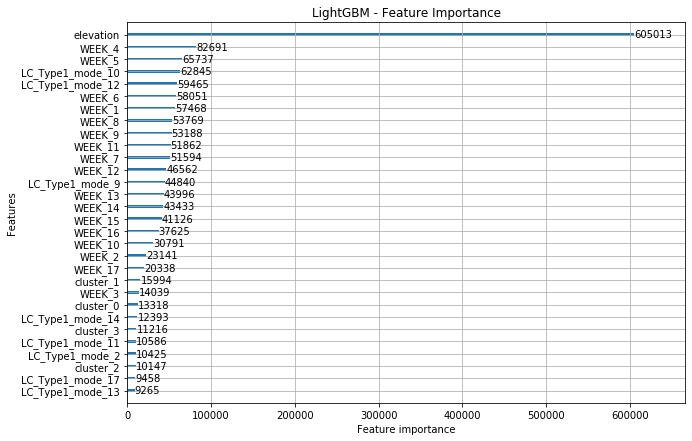

In [142]:
#feature importance
fig, ax = plt.subplots(figsize=(10, 7))
lgb.plot_importance(lgb_clf, max_num_features=30, ax=ax)
plt.title("LightGBM - Feature Importance");

In [143]:
# test prediction
prediction_light = lgb_clf.predict(X_test3)

In [144]:
#cross validation
lgb_params = {
    'learning_rate': 0.01,
    'max_depth': 5,
    'num_leaves': 40, 
    'objective': 'regression',
    'tree_learner':'voting',
    'metric':'rmse',
    'feature_fraction': 0.6,
    'bagging_fraction': 0.75,
    'max_bin': 100}

# LightGBM, cross-validation
cv_result_lgb = lgb.cv(lgb_params, 
                       lgtrain, 
                       num_boost_round=1000, 
                       nfold=5, 
                       stratified=False, 
                       early_stopping_rounds=500, 
                       verbose_eval=500, 
                       )

num_boost_rounds_lgb = len(cv_result_lgb['rmse-mean'])
print('num_boost_rounds_lgb=' + str(num_boost_rounds_lgb))
# train model
model_lgb = lgb.train(lgb_params, lgtrain, num_boost_round=num_boost_rounds_lgb)


[500]	cv_agg's rmse: 0.127182 + 0.00477831
[1000]	cv_agg's rmse: 0.122771 + 0.0042805
num_boost_rounds_lgb=1000


In [145]:
#test prediction
prediction_light = model_lgb.predict(X_test3)

In [146]:
#convert to pandas dataframe
prediction_light_df = pd.Series(prediction_light)
predicted_xgb_df = pd.Series(predicted_xgb)
prediction_cat_df = pd.Series(prediction_cat1)

In [147]:
#generate outputs
#xgboost
submission = pd.concat([test_id, predicted_xgb_df], axis=1)
submission.columns = ["Square_ID","target_2019"]
submission.to_csv("submission_xgbm.csv",index=False)


In [148]:
#catboost
submission = pd.concat([test_id, prediction_cat_df], axis=1)
submission.columns = ["Square_ID","target_2019"]
submission.to_csv("submission_cat.csv",index=False)

In [149]:
#lgbm
submission = pd.concat([test_id, prediction_light_df], axis=1)
submission.columns = ["Square_ID","target_2019"]
submission.to_csv("submission_light.csv",index=False)

In [ ]:
#generate new data with different without one hot encoding

In [152]:
categorical = ['LC_Type1_mode',"cluster"]

In [158]:
X = train_df.drop(['target'], axis=1)
y = train_df.target

In [159]:
X_train = X
X_test = X
y_train = y
y_test = y

In [162]:
#Categorical data
train_cat = X_train[['LC_Type1_mode',"cluster"]] 
train_cat.reset_index(drop=True, inplace=True)

test_cat = X_test[['LC_Type1_mode',"cluster"]]
test_cat.reset_index(drop=True, inplace=True)

In [163]:
#train
scaler = preprocessing.MinMaxScaler()
to_scale_df = X_train[['elevation','WEEK_1','WEEK_2',
 'WEEK_3','WEEK_4','WEEK_5','WEEK_6','WEEK_7','WEEK_8','WEEK_9','WEEK_10','WEEK_11',
                    'WEEK_12','WEEK_13','WEEK_14','WEEK_15','WEEK_16','WEEK_17']]
train_scaled_df = scaler.fit_transform(to_scale_df)
train_scaled_df = pd.DataFrame(train_scaled_df, columns=['elevation','WEEK_1','WEEK_2',
 'WEEK_3','WEEK_4','WEEK_5','WEEK_6','WEEK_7','WEEK_8','WEEK_9','WEEK_10','WEEK_11',
                    'WEEK_12','WEEK_13','WEEK_14','WEEK_15','WEEK_16','WEEK_17'])
train_scaled_df.reset_index(drop=True, inplace=True)

#test
scaler = preprocessing.MinMaxScaler()
to_scale_df = X_test[['elevation','WEEK_1','WEEK_2',
 'WEEK_3','WEEK_4','WEEK_5','WEEK_6','WEEK_7','WEEK_8','WEEK_9','WEEK_10','WEEK_11',
                    'WEEK_12','WEEK_13','WEEK_14','WEEK_15','WEEK_16','WEEK_17']] 
test_scaled_df = scaler.fit_transform(to_scale_df)
test_scaled_df = pd.DataFrame(test_scaled_df, columns=['elevation','WEEK_1','WEEK_2',
 'WEEK_3','WEEK_4','WEEK_5','WEEK_6','WEEK_7','WEEK_8','WEEK_9','WEEK_10','WEEK_11',
                    'WEEK_12','WEEK_13','WEEK_14','WEEK_15','WEEK_16','WEEK_17'])
test_scaled_df.reset_index(drop=True, inplace=True)

In [164]:
#train square id
train_id = X_train['Square_ID']
train_id .reset_index(drop=True, inplace=True)

#test square id
test_id = X_test['Square_ID']
test_id .reset_index(drop=True, inplace=True)

In [169]:
#combine
train_outcome = y_train
train_outcome.reset_index(drop=True, inplace=True)
train_df_final = pd.concat([train_scaled_df, train_cat,train_outcome], axis=1)
train_df_final.head()

test_outcome = y_test
test_outcome.reset_index(drop=True, inplace=True)
test_df_final = pd.concat([test_scaled_df, test_cat,test_outcome], axis=1)
test_df_final.head()

,elevation,WEEK_1,WEEK_2,WEEK_3,WEEK_4,WEEK_5,WEEK_6,WEEK_7,WEEK_8,WEEK_9,...,WEEK_11,WEEK_12,WEEK_13,WEEK_14,WEEK_15,WEEK_16,WEEK_17,LC_Type1_mode,cluster,target
0,0.305401,0.0,0.0,0.0,0.769368,0.563732,0.535691,0.909368,0.407291,0.0,...,0.379124,0.631178,0.274751,0.044375,0.328427,0.000938,0.0,9,4,0.0
1,0.253054,0.0,0.0,0.0,0.769368,0.563732,0.535691,0.909368,0.407291,0.0,...,0.379124,0.631178,0.274751,0.044375,0.328427,0.000938,0.0,9,4,0.0
2,0.188626,0.0,0.0,0.0,0.769368,0.563732,0.535691,0.909368,0.407291,0.0,...,0.379124,0.631178,0.274751,0.044375,0.328427,0.000938,0.0,9,4,0.0
3,0.144266,0.0,0.0,0.0,0.769368,0.563732,0.535691,0.909368,0.407291,0.0,...,0.379124,0.631178,0.274751,0.044375,0.328427,0.000938,0.0,10,4,0.0
4,0.142109,0.0,0.0,0.0,0.769368,0.563732,0.535691,0.909368,0.407291,0.0,...,0.379124,0.631178,0.274751,0.044375,0.328427,0.000938,0.0,10,4,0.0


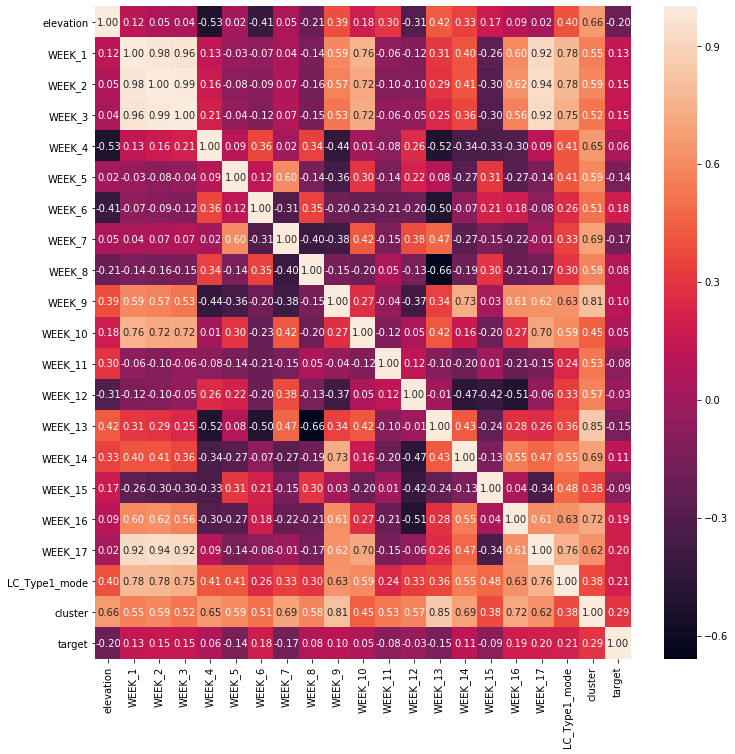

In [216]:
#correlation
nominal.associations(train_df_final, correlation_ratio=True, 
                     nominal_columns=categorical,
                     figsize=(12,12))

In [170]:
#xgboost
target_encode_columns = categorical
target = ['target']
target_encode_df = train_df_final[target_encode_columns + target].reset_index().drop(columns = 'index', axis = 1)
target_name = target[0]
target_df = pd.DataFrame()
for embed_col in target_encode_columns:
    val_map = target_encode_df.groupby(embed_col)[target].mean().to_dict()[target_name]
    target_df[embed_col] = target_encode_df[embed_col].map(val_map).values
    
score_target_drop = train_df_final.drop(target_encode_columns, axis = 1).reset_index().drop(columns = 'index', axis = 1)
score_target = pd.concat([score_target_drop, target_df], axis = 1)

In [171]:
#test
target_encode_columns = categorical
target = ['target']
target_encode_df = test_df_final[target_encode_columns + target].reset_index().drop(columns = 'index', axis = 1)
target_name = target[0]
target_df = pd.DataFrame()
for embed_col in target_encode_columns:
    val_map = target_encode_df.groupby(embed_col)[target].mean().to_dict()[target_name]
    target_df[embed_col] = target_encode_df[embed_col].map(val_map).values
    
score_target_drop = test_df_final.drop(target_encode_columns, axis = 1).reset_index().drop(columns = 'index', axis = 1)
score_test = pd.concat([score_target_drop, target_df], axis = 1)

In [173]:
#split training data set
X_train1 = score_target.drop(['target'], axis=1)
y_train1 = score_target.target

#split test dataset
X_test1 = score_test.drop(['target'], axis=1)
y_test1 = score_test.target



In [230]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.01, max_depth = 16, 
                          alpha = 10, n_estimators = 10)

In [231]:
xg_reg.fit(X_train1,y_train1)
preds = xg_reg.predict(X_test1)

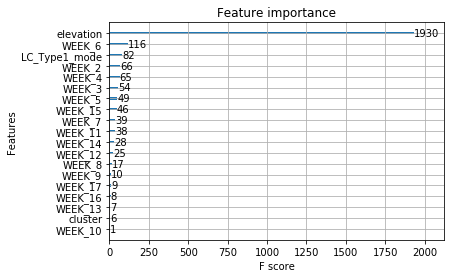

In [232]:
import matplotlib.pyplot as plt
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [176]:
params = {'colsample_bytree': uniform(0.7, 0.3),
          'gamma': uniform(0, 0.5),
          'learning_rate': uniform(0.003, 0.3), # default 0.1 
          'max_depth': randint(2, 6), # default 3
          'n_estimators': randint(100, 250), # default 100
          'subsample': uniform(0.6, 0.4)}
xgb_model = xgb.XGBRegressor(objective="reg:squarederror",random_state=1)
time_split = TimeSeriesSplit(n_splits = 8)
xgb_search = RandomizedSearchCV(xgb_model,param_distributions=params, 
                                random_state=1, n_iter=4, cv=time_split, 
                                  verbose=1, n_jobs=1, return_train_score=True)  

In [178]:
xgb_search.fit(X_train1, y_train1)

Fitting 8 folds for each of 4 candidates, totalling 32 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:  1.3min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=8),
                   error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a239859e8>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a2b6d8c50>,
      

In [179]:
predicted_xgb = xgb_search.predict(X_test1)
rms = sqrt(mean_squared_error(y_test1, predicted_xgb))
print ('RMSE:', rms)

RMSE: 0.14065372243361765


In [ ]:
#catboost

In [182]:
#split training data set
X_train2 = train_df_final.drop(['target'], axis=1)
y_train2 = train_df_final.target

#split test dataset
X_test2 = test_df_final.drop(['target'], axis=1)
y_test2 = test_df_final.target

In [183]:
def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols, query_cols, sorter=sidx)]

categorical_features_indices = column_index(X_train2, categorical)
categorical_features_indices1 = column_index(X_test2, categorical)

In [184]:
model=CatBoostRegressor(iterations=500, depth=10, learning_rate=0.01, loss_function='RMSE')

model.fit(X_train2, y_train2,cat_features=categorical_features_indices,eval_set=(X_test2, y_test2),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2273679	test: 0.2273679	best: 0.2273679 (0)	total: 1.58s	remaining: 13m 6s
1:	learn: 0.2260414	test: 0.2260414	best: 0.2260414 (1)	total: 2.48s	remaining: 10m 16s
2:	learn: 0.2247715	test: 0.2247715	best: 0.2247715 (2)	total: 3.35s	remaining: 9m 14s
3:	learn: 0.2235325	test: 0.2235325	best: 0.2235325 (3)	total: 3.81s	remaining: 7m 52s
4:	learn: 0.2222587	test: 0.2222587	best: 0.2222587 (4)	total: 4.36s	remaining: 7m 11s
5:	learn: 0.2210166	test: 0.2210166	best: 0.2210166 (5)	total: 4.88s	remaining: 6m 41s
6:	learn: 0.2197495	test: 0.2197495	best: 0.2197495 (6)	total: 5.39s	remaining: 6m 19s
7:	learn: 0.2185377	test: 0.2185377	best: 0.2185377 (7)	total: 5.82s	remaining: 5m 58s
8:	learn: 0.2173410	test: 0.2173410	best: 0.2173410 (8)	total: 6.34s	remaining: 5m 46s
9:	learn: 0.2161132	test: 0.2161132	best: 0.2161132 (9)	total: 6.78s	remaining: 5m 32s
10:	learn: 0.2149636	test: 0.2149636	best: 0.2149636 (10)	total: 7.33s	remaining: 5m 25s
11:	learn: 0.2138019	test: 0.2138019	bes

93:	learn: 0.1564179	test: 0.1564182	best: 0.1564182 (93)	total: 54.7s	remaining: 3m 56s
94:	learn: 0.1559891	test: 0.1559893	best: 0.1559893 (94)	total: 55.4s	remaining: 3m 56s
95:	learn: 0.1556340	test: 0.1556342	best: 0.1556342 (95)	total: 55.6s	remaining: 3m 54s
96:	learn: 0.1553012	test: 0.1553015	best: 0.1553015 (96)	total: 55.7s	remaining: 3m 51s
97:	learn: 0.1549689	test: 0.1549692	best: 0.1549692 (97)	total: 55.8s	remaining: 3m 48s
98:	learn: 0.1545956	test: 0.1545959	best: 0.1545959 (98)	total: 56.8s	remaining: 3m 50s
99:	learn: 0.1542386	test: 0.1542389	best: 0.1542389 (99)	total: 57s	remaining: 3m 47s
100:	learn: 0.1538978	test: 0.1538981	best: 0.1538981 (100)	total: 57.8s	remaining: 3m 48s
101:	learn: 0.1535367	test: 0.1535370	best: 0.1535370 (101)	total: 58.4s	remaining: 3m 47s
102:	learn: 0.1532314	test: 0.1532323	best: 0.1532323 (102)	total: 59.1s	remaining: 3m 47s
103:	learn: 0.1529060	test: 0.1529070	best: 0.1529070 (103)	total: 60s	remaining: 3m 48s
104:	learn: 0.152

183:	learn: 0.1351252	test: 0.1351780	best: 0.1351780 (183)	total: 1m 45s	remaining: 3m
184:	learn: 0.1350017	test: 0.1350561	best: 0.1350561 (184)	total: 1m 45s	remaining: 3m
185:	learn: 0.1348480	test: 0.1349025	best: 0.1349025 (185)	total: 1m 46s	remaining: 2m 59s
186:	learn: 0.1347061	test: 0.1347603	best: 0.1347603 (186)	total: 1m 46s	remaining: 2m 58s
187:	learn: 0.1345907	test: 0.1346768	best: 0.1346768 (187)	total: 1m 47s	remaining: 2m 58s
188:	learn: 0.1344728	test: 0.1345585	best: 0.1345585 (188)	total: 1m 47s	remaining: 2m 57s
189:	learn: 0.1343590	test: 0.1344639	best: 0.1344639 (189)	total: 1m 48s	remaining: 2m 56s
190:	learn: 0.1342162	test: 0.1343206	best: 0.1343206 (190)	total: 1m 49s	remaining: 2m 56s
191:	learn: 0.1340948	test: 0.1342077	best: 0.1342077 (191)	total: 1m 49s	remaining: 2m 55s
192:	learn: 0.1339500	test: 0.1340627	best: 0.1340627 (192)	total: 1m 50s	remaining: 2m 55s
193:	learn: 0.1338268	test: 0.1339392	best: 0.1339392 (193)	total: 1m 50s	remaining: 2m 

273:	learn: 0.1272456	test: 0.1275313	best: 0.1275313 (273)	total: 2m 33s	remaining: 2m 6s
274:	learn: 0.1271910	test: 0.1274752	best: 0.1274752 (274)	total: 2m 34s	remaining: 2m 6s
275:	learn: 0.1271380	test: 0.1274232	best: 0.1274232 (275)	total: 2m 34s	remaining: 2m 5s
276:	learn: 0.1270746	test: 0.1273597	best: 0.1273597 (276)	total: 2m 35s	remaining: 2m 4s
277:	learn: 0.1270171	test: 0.1273027	best: 0.1273027 (277)	total: 2m 35s	remaining: 2m 4s
278:	learn: 0.1269766	test: 0.1272624	best: 0.1272624 (278)	total: 2m 36s	remaining: 2m 3s
279:	learn: 0.1269225	test: 0.1272157	best: 0.1272157 (279)	total: 2m 36s	remaining: 2m 3s
280:	learn: 0.1268909	test: 0.1271844	best: 0.1271844 (280)	total: 2m 37s	remaining: 2m 2s
281:	learn: 0.1268400	test: 0.1271325	best: 0.1271325 (281)	total: 2m 38s	remaining: 2m 2s
282:	learn: 0.1267664	test: 0.1270577	best: 0.1270577 (282)	total: 2m 38s	remaining: 2m 1s
283:	learn: 0.1267067	test: 0.1269970	best: 0.1269970 (283)	total: 2m 39s	remaining: 2m 1s

363:	learn: 0.1236350	test: 0.1241958	best: 0.1241958 (363)	total: 3m 22s	remaining: 1m 15s
364:	learn: 0.1236126	test: 0.1241826	best: 0.1241826 (364)	total: 3m 22s	remaining: 1m 14s
365:	learn: 0.1235986	test: 0.1241701	best: 0.1241701 (365)	total: 3m 23s	remaining: 1m 14s
366:	learn: 0.1235735	test: 0.1241497	best: 0.1241497 (366)	total: 3m 23s	remaining: 1m 13s
367:	learn: 0.1235500	test: 0.1241305	best: 0.1241305 (367)	total: 3m 24s	remaining: 1m 13s
368:	learn: 0.1235244	test: 0.1241081	best: 0.1241081 (368)	total: 3m 24s	remaining: 1m 12s
369:	learn: 0.1234889	test: 0.1240723	best: 0.1240723 (369)	total: 3m 25s	remaining: 1m 12s
370:	learn: 0.1234817	test: 0.1240660	best: 0.1240660 (370)	total: 3m 25s	remaining: 1m 11s
371:	learn: 0.1234590	test: 0.1240446	best: 0.1240446 (371)	total: 3m 26s	remaining: 1m 11s
372:	learn: 0.1234195	test: 0.1240062	best: 0.1240062 (372)	total: 3m 27s	remaining: 1m 10s
373:	learn: 0.1233813	test: 0.1239668	best: 0.1239668 (373)	total: 3m 27s	remain

454:	learn: 0.1215033	test: 0.1222302	best: 0.1222302 (454)	total: 4m 9s	remaining: 24.6s
455:	learn: 0.1214827	test: 0.1222085	best: 0.1222085 (455)	total: 4m 9s	remaining: 24.1s
456:	learn: 0.1214709	test: 0.1222001	best: 0.1222001 (456)	total: 4m 10s	remaining: 23.5s
457:	learn: 0.1214607	test: 0.1221926	best: 0.1221926 (457)	total: 4m 10s	remaining: 23s
458:	learn: 0.1214486	test: 0.1221810	best: 0.1221810 (458)	total: 4m 11s	remaining: 22.4s
459:	learn: 0.1214346	test: 0.1221665	best: 0.1221665 (459)	total: 4m 11s	remaining: 21.9s
460:	learn: 0.1214082	test: 0.1221470	best: 0.1221470 (460)	total: 4m 12s	remaining: 21.4s
461:	learn: 0.1214038	test: 0.1221430	best: 0.1221430 (461)	total: 4m 12s	remaining: 20.8s
462:	learn: 0.1213882	test: 0.1221275	best: 0.1221275 (462)	total: 4m 13s	remaining: 20.2s
463:	learn: 0.1213790	test: 0.1221230	best: 0.1221230 (463)	total: 4m 13s	remaining: 19.7s
464:	learn: 0.1213749	test: 0.1221189	best: 0.1221189 (464)	total: 4m 13s	remaining: 19.1s
465

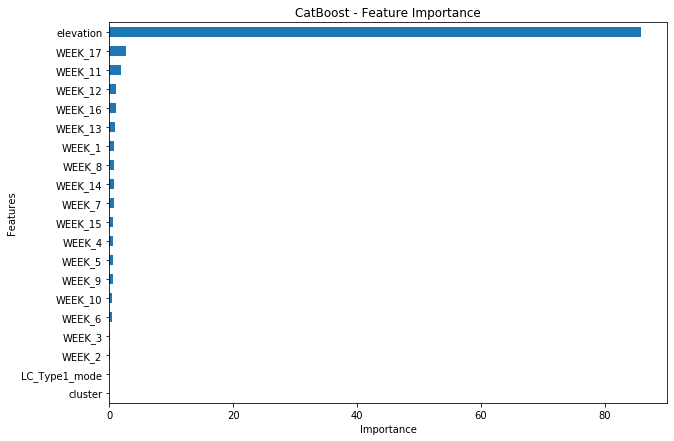

In [217]:
#Catboost feature importance
fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': X_train2.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

In [198]:
#Catboost parameter tuning
model =  CatBoostRegressor(iterations=100,
                             learning_rate=0.01,
                             depth=16,
                             eval_metric='RMSE',
                             random_seed = 1,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 75,
                             od_wait=100)


model.fit(X_train2, y_train2,
                 eval_set=(X_test2, y_test2),
                 cat_features=categorical,
                 use_best_model=True)

0:	learn: 0.2273845	test: 0.2273845	best: 0.2273845 (0)	total: 4.97s	remaining: 8m 12s
75:	learn: 0.1610706	test: 0.1610706	best: 0.1610706 (75)	total: 5m 19s	remaining: 1m 40s
99:	learn: 0.1502556	test: 0.1502556	best: 0.1502556 (99)	total: 7m 2s	remaining: 0us

bestTest = 0.1502556164
bestIteration = 99



In [199]:
from sklearn.metrics import mean_squared_error
print("RMSE of the validation set:", np.sqrt(mean_squared_error(y_test2, model.predict(X_test2))))

RMSE of the validation set: 0.1502556163868871


In [200]:
#build test prediction
predicted_cat = model.predict(X_test2)

In [ ]:
#light gbm

In [201]:
df_train1 = train_df_final
df_test1 = test_df_final

In [202]:
label_encoder = preprocessing.LabelEncoder()
for col in categorical:
    df_train1[col] = label_encoder.fit_transform(df_train1[col].astype(str))
    df_test1[col] = label_encoder.fit_transform(df_test1[col].astype(str))

In [203]:
#split training data set
X_train3 = df_train1.drop(['target'], axis=1)
y_train3 = df_train1.target

#split test dataset
X_test3 = df_test1.drop(['target'], axis=1)
y_test3 = df_test1.target

In [204]:
X = df_train1.loc[:, df_train1.columns != 'target']
feature_names = X.columns.tolist()

In [205]:
# LightGBM dataset formatting 
lgtrain = lgb.Dataset(X_train3, y_train3,
                feature_name=feature_names,
                categorical_feature = categorical)
lgvalid = lgb.Dataset(X_test3, y_test3,
                feature_name=feature_names,
                categorical_feature = categorical)

In [206]:
params = {
    'objective' : 'regression',
    'metric' : 'rmse',
    'num_leaves' : 200,
    'max_depth': 15,
    'learning_rate' : 0.01,
    'feature_fraction' : 0.6,
    'verbosity' : -1
}

lgb_clf = lgb.train(
    params,
    lgtrain,
    20000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train', 'test'],
    early_stopping_rounds=500,
    verbose_eval=500
)

Training until validation scores don't improve for 500 rounds
[500]	train's rmse: 0.109795	test's rmse: 0.109795
[1000]	train's rmse: 0.106741	test's rmse: 0.106741
[1500]	train's rmse: 0.105674	test's rmse: 0.105674
[2000]	train's rmse: 0.104999	test's rmse: 0.104999
[2500]	train's rmse: 0.104351	test's rmse: 0.104351
[3000]	train's rmse: 0.103746	test's rmse: 0.103746
[3500]	train's rmse: 0.103304	test's rmse: 0.103304
[4000]	train's rmse: 0.102958	test's rmse: 0.102958
[4500]	train's rmse: 0.102734	test's rmse: 0.102734
[5000]	train's rmse: 0.102529	test's rmse: 0.102529
[5500]	train's rmse: 0.102372	test's rmse: 0.102372
[6000]	train's rmse: 0.102246	test's rmse: 0.102246
[6500]	train's rmse: 0.10207	test's rmse: 0.10207
[7000]	train's rmse: 0.101884	test's rmse: 0.101884
[7500]	train's rmse: 0.101743	test's rmse: 0.101743
[8000]	train's rmse: 0.101619	test's rmse: 0.101619
[8500]	train's rmse: 0.101487	test's rmse: 0.101487
[9000]	train's rmse: 0.101387	test's rmse: 0.101387
[9500

In [207]:
from sklearn.metrics import mean_squared_error
print("RMSE of the validation set:", np.sqrt(mean_squared_error(y_test3, lgb_clf.predict(X_test3))))

RMSE of the validation set: 0.10005489975054584


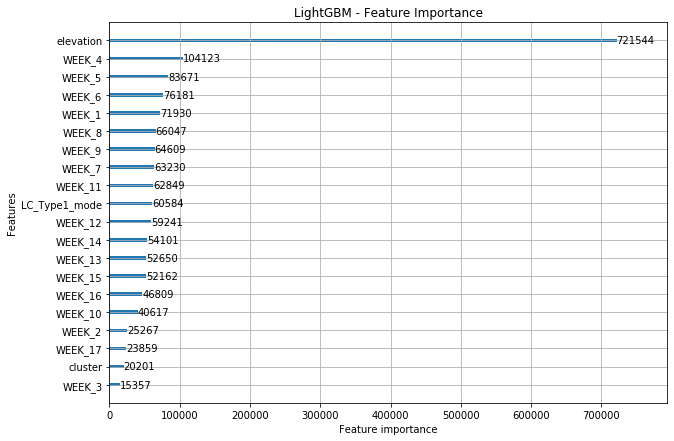

In [208]:
#feature importance
fig, ax = plt.subplots(figsize=(10, 7))
lgb.plot_importance(lgb_clf, max_num_features=30, ax=ax)
plt.title("LightGBM - Feature Importance");

In [209]:
# test prediction
prediction_light = lgb_clf.predict(X_test3)

In [221]:
#cross validation
lgb_params = {
    'learning_rate': 0.01,
    'max_depth': 5,
    'num_leaves': 40, 
    'objective': 'regression',
    'tree_learner':'voting',
    'metric':'rmse',
    'feature_fraction': 0.6,
    'bagging_fraction': 0.75,
    'max_bin': 100}

# LightGBM, cross-validation
cv_result_lgb = lgb.cv(lgb_params, 
                       lgtrain, 
                       num_boost_round=1000, 
                       nfold=5, 
                       stratified=False, 
                       early_stopping_rounds=500, 
                       verbose_eval=500, 
                       categorical_feature = categorical
                       )

num_boost_rounds_lgb = len(cv_result_lgb['rmse-mean'])
print('num_boost_rounds_lgb=' + str(num_boost_rounds_lgb))



[500]	cv_agg's rmse: 0.129296 + 0.00511108
[1000]	cv_agg's rmse: 0.123755 + 0.0046239
num_boost_rounds_lgb=1000


In [225]:
prediction_light = lgb_clf.predict(X_test3)

In [212]:
#convert to pandas dataframe
prediction_light_df = pd.Series(prediction_light)
predicted_xgb_df = pd.Series(predicted_xgb)
prediction_cat_df = pd.Series(prediction_cat1)

#generate outputs
#xgboost
submission = pd.concat([test_id, predicted_xgb_df], axis=1)
submission.columns = ["Square_ID","target_2019"]
submission.to_csv("submission_xgbm1.csv",index=False)

#catboost
submission = pd.concat([test_id, prediction_cat_df], axis=1)
submission.columns = ["Square_ID","target_2019"]
submission.to_csv("submission_cat1.csv",index=False)

#lgbm
submission = pd.concat([test_id, prediction_light_df], axis=1)
submission.columns = ["Square_ID","target_2019"]
submission.to_csv("submission_light1.csv",index=False)

In [ ]:
#use only a handful of features